In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import math
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

### Генерация сетки

In [34]:
def generate_mesh(r_min, r_max, I):
    
    r = np.zeros(I + 2)
    h = (r_max - r_min) / I
    for i in range(0, I + 2):
        r[i] = r_min + (i - 0.5) * h
        
    return r, h

### Вычисление функций и производных из задачи 1

In [35]:
def v0(r):
    
    top = 2 * r - (a + b)
    bottom = (b - a) ** 2 - top ** 2
    result = np.where((a < r) & ( r < b), np.exp(-4 * top ** 2 / bottom), 0)
    
    return result

In [36]:
def dv0(r):
    #dv0/dr в точке r
    top = 2 * r - (a + b)
    bottom = (b - a) ** 2 - top ** 2
    exp_term = np.exp(-4 * top ** 2 / bottom)
    result = np.where((a < r) & (r < b), 
                      (-16 * top ** 3 / bottom ** 2 - 16 * top / bottom) * exp_term,
                      0)
    return result

## Задача 3

In [37]:
def U(r):
    return v0(r)

In [38]:
def dU(r):
    return dv0(r)

In [39]:
def u1__(r, t):

    return r ** ((1 - d) / 2)  * U(c * t - r)

In [40]:
def du1__(r, t):
    return (1 - d)/2 * r ** (-(1 + d) / 2) * U(c * t - r) - r ** ((1 - d) / 2) * dU(c * t - r)

In [41]:
def f(r, t):
    return (c ** 2) * (d - 1) * (d - 3) * U(c * t - r) / (4 * r ** ((d + 3) / 2))

In [42]:
def solver2(r_max, r_min, I, C, c, T):

    r, h = generate_mesh(r_min, r_max, I)
    tau = C * h / c
    current_time = tau
    
    u = np.zeros((3, len(r)))
    u[1] = u1__(r, 0)
    u[2] = u1__(r, tau)

    
    results = [u[1].copy()]
    results_an = [u[1].copy()]
    times = [0]

    
    while current_time < T:

        results.append(u[2].copy())
        results_an.append(u1__(r, current_time))
        times.append(current_time)
        u[0], u[1] = u[1].copy(), u[2].copy()

        for i in range(1, I + 1):
            u[2, i] = (2 * u[1, i] - u[0, i] +
                ((c * tau) ** 2) / (h * r[i] ** (d - 1)) * (
                    ((r[i + 1] + r[i]) / 2) ** (d - 1) * (u[1, i + 1] - u[1, i]) / h -
                    ((r[i] + r[i - 1]) / 2) ** (d - 1) * (u[1, i] - u[1, i - 1]) / h) +
                (tau ** 2) * f(r[i], current_time))

        current_time += tau

        u[2, 0] = u[2, 1] - h * du1__(r_min, current_time) 
        u[2, -1] = u[2, -2] + h * du1__(r_max, current_time)
       
        
    results.append(u[2].copy())
    results_an.append(u1__(r, current_time))
    times.append(current_time)

    return np.array(results), np.array(times), r, h, np.array(results_an)

In [43]:
def compute_error(numerical, analytical):
    return np.max(np.abs(numerical - analytical))

In [44]:
def calculate_norms2(u1, u2, u_analytical):

    C_arr = []; L2_arr = []
    for i in range(u1.shape[0]):
        diff1 = abs(u1[i] - u_analytical[i])
        diff2 = abs(u2[i] - u_analytical[i])
        C = np.linalg.norm(diff1, ord=np.inf) / np.linalg.norm(diff2, ord=np.inf)
        L2 = np.linalg.norm(diff1, ord=2) / np.linalg.norm(diff2, ord=2)
        C_arr.append(C); L2_arr.append(L2)
    
    return C_arr, L2_arr

In [45]:
def calculate_for_meshes2(I):
    solutions = []; times = []; grids = []; u_an = []
    for mesh in I:
        u, t, r, h, u_analyt = solver2(r_max, r_min, mesh, C, c, T)
        solutions.append(u)
        times.append(t)
        grids.append(r)
        u_an.append(u_analyt)
    return solutions, times, grids, u_an

In [46]:
r_min = 0.1
r_max = 1.8
a = 0.6
b = 1.2
c = 1.5

In [47]:
I = 100
T = 3    
C = 0.9
d = 1

### α = 1/3,  R1

In [48]:
grids_arr = [200, 600]
solutions, times, grids, u_an = calculate_for_meshes2(grids_arr)    

In [49]:
u1_, u2_ = solutions[0], solutions[1]
T1, T2 = times[0], times[1]
r1, r2 = grids[0], grids[1]
u_an = u_an[0]

In [50]:
step1 = T2.shape[0] // T1.shape[0]
u1_cut = u1_[1:-1, 1:-1]
r1_cut = r1[1:-1]
r2_cut = r2[3::3] 
u2_cut = u2_[3::3, step1::step1+1] 
T1_cut = T1[1:-1]
u_an_cut = u_an[1:-1, 1:-1]

In [51]:
print("Time shape", T1_cut.shape)
print("Shape of u", u1_cut.shape)
print("Shape of u_alpha:", u2_cut.shape)
print("Shape of u_analytical", u_an_cut.shape)

Time shape (588,)
Shape of u (588, 200)
Shape of u_alpha: (588, 200)
Shape of u_analytical (588, 200)


In [52]:
compute_error(u1_cut, u_an_cut)

0.0040750685376181334

In [53]:
compute_error(u2_cut, u_an_cut)

0.00044796033861934856

In [54]:
C, L2 = calculate_norms2(u1_cut, u2_cut, u_an_cut)

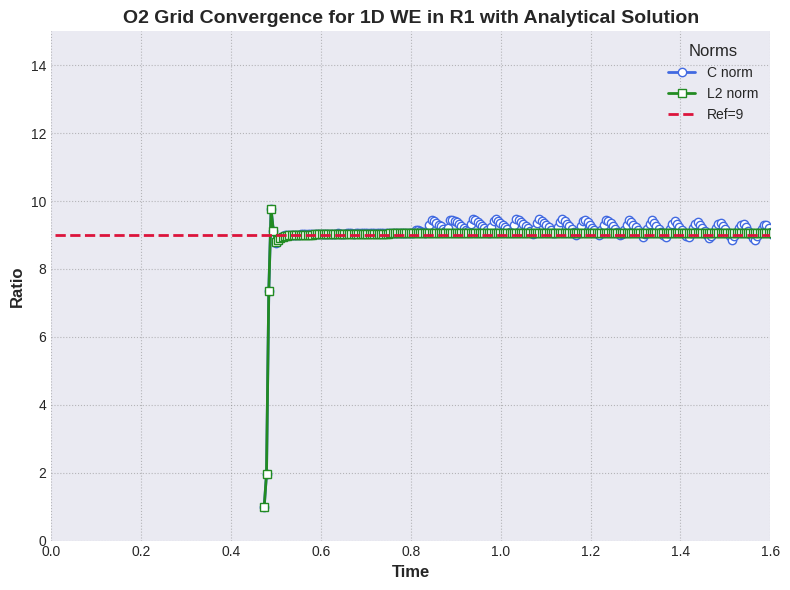

In [55]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))  
ax.set_ylim(0, 15)
ax.set_xlim(0, 1.6)
ax.plot(T1_cut, C, label='C norm', color='royalblue', linewidth=2, marker='o', markersize=6, markerfacecolor='white')
ax.plot(T1_cut, L2, label='L2 norm', color='forestgreen', linewidth=2, marker='s', markersize=6, markerfacecolor='white')
ax.axhline(y=9, xmin=np.min(T1_cut), xmax=np.max(T1_cut), label="Ref=9", color='crimson', linestyle='--', linewidth=2)

ax.grid(True, linestyle=':', color='gray', alpha=0.5)
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Ratio", fontsize=12, fontweight='bold')
ax.set_title(f"O2 Grid Convergence for 1D WE in R{d} with Analytical Solution", fontsize=14, fontweight='bold')


ax.legend(loc='upper right', fontsize=10, frameon=False, title="Norms", title_fontsize=12)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()  
plt.savefig('Grid_convergence_analytical_R1.png')
plt.show()

### α = 1/3,  R2

In [56]:
d = 2; C = 0.9
grids_arr = [200, 600]
solutions, times, grids, u_an = calculate_for_meshes2(grids_arr)    
u1_, u2_ = solutions[0], solutions[1]
T1, T2 = times[0], times[1]
r1, r2 = grids[0], grids[1]
u_an = u_an[0]
step1 = T2.shape[0] // T1.shape[0]
u1_cut = u1_[1:-1, 1:-1]
r1_cut = r1[1:-1]
r2_cut = r2[3::3] 
u2_cut = u2_[3::3, step1::step1+1] 
T1_cut = T1[1:-1]
u_an_cut = u_an[1:-1, 1:-1]
C, L2 = calculate_norms2(u1_cut, u2_cut, u_an_cut)

In [57]:
compute_error(u1_cut, u_an_cut)

0.011194212430726545

In [58]:
compute_error(u2_cut, u_an_cut)

0.0013246240936653226

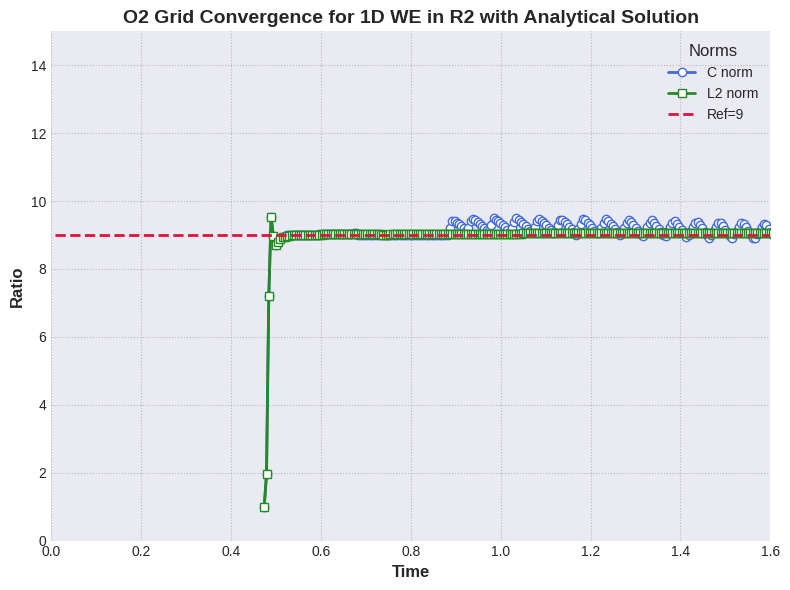

In [59]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))  
ax.set_ylim(0, 15)
ax.set_xlim(0, 1.6)
ax.plot(T1_cut, C, label='C norm', color='royalblue', linewidth=2, marker='o', markersize=6, markerfacecolor='white')
ax.plot(T1_cut, L2, label='L2 norm', color='forestgreen', linewidth=2, marker='s', markersize=6, markerfacecolor='white')
ax.axhline(y=9, xmin=np.min(T1_cut), xmax=np.max(T1_cut), label="Ref=9", color='crimson', linestyle='--', linewidth=2)

ax.grid(True, linestyle=':', color='gray', alpha=0.5)
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Ratio", fontsize=12, fontweight='bold')
ax.set_title(f"O2 Grid Convergence for 1D WE in R{d} with Analytical Solution", fontsize=14, fontweight='bold')


ax.legend(loc='upper right', fontsize=10, frameon=False, title="Norms", title_fontsize=12)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()  
plt.savefig('Grid_convergence_analytical_R2.png')

### α = 1/3,  R3

In [60]:
d = 3; C = 0.9
grids_arr = [200, 600]
solutions, times, grids, u_an = calculate_for_meshes2(grids_arr)    
u1_, u2_ = solutions[0], solutions[1]
T1, T2 = times[0], times[1]
r1, r2 = grids[0], grids[1]
u_an = u_an[0]
step1 = T2.shape[0] // T1.shape[0]
u1_cut = u1_[1:-1, 1:-1]
r1_cut = r1[1:-1]
r2_cut = r2[3::3] 
u2_cut = u2_[3::3, step1::step1+1] 
T1_cut = T1[1:-1]
u_an_cut = u_an[1:-1, 1:-1]
C, L2 = calculate_norms2(u1_cut, u2_cut, u_an_cut)

In [61]:
compute_error(u1_cut, u_an_cut)

0.03096771829396111

In [62]:
compute_error(u2_cut, u_an_cut)

0.0037890916819852023

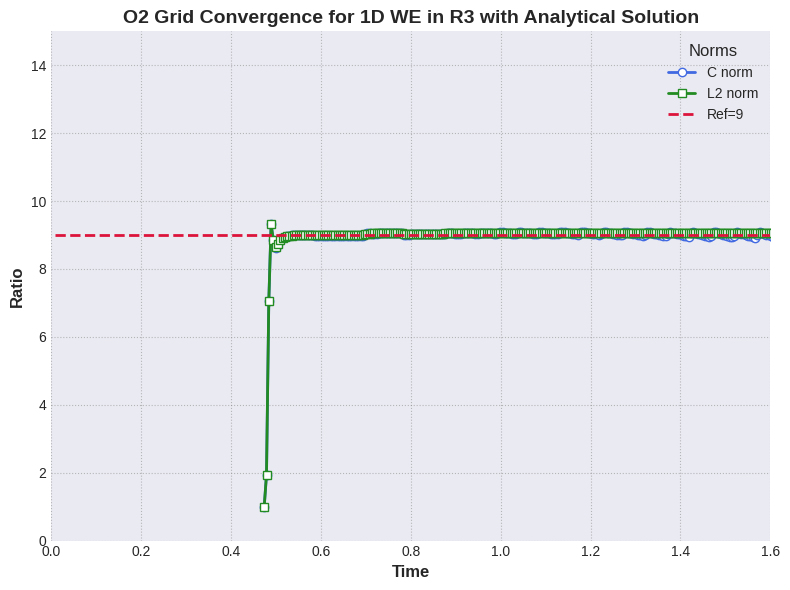

In [63]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(8, 6))  
ax.set_ylim(0, 15)
ax.set_xlim(0, 1.6)
ax.plot(T1_cut, C, label='C norm', color='royalblue', linewidth=2, marker='o', markersize=6, markerfacecolor='white')
ax.plot(T1_cut, L2, label='L2 norm', color='forestgreen', linewidth=2, marker='s', markersize=6, markerfacecolor='white')
ax.axhline(y=9, xmin=np.min(T1_cut), xmax=np.max(T1_cut), label="Ref=9", color='crimson', linestyle='--', linewidth=2)

ax.grid(True, linestyle=':', color='gray', alpha=0.5)
ax.set_xlabel("Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Ratio", fontsize=12, fontweight='bold')
ax.set_title(f"O2 Grid Convergence for 1D WE in R{d} with Analytical Solution", fontsize=14, fontweight='bold')


ax.legend(loc='upper right', fontsize=10, frameon=False, title="Norms", title_fontsize=12)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()  
plt.savefig('Grid_convergence_analytical_R3.png')